## Pacotes

In [1]:
!pip install geojson owslib matplotlib-scalebar rasterio geopandas matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 240.1/240.1 kB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 40.5 MB/s eta 0:00:00


## Importando bibliotecas

In [2]:
import numpy as np
import geopandas as gpd
import requests
import geojson
import rasterio
from rasterio.io import MemoryFile
from rasterio.warp import calculate_default_transform, reproject, Resampling
from pyproj import CRS
from owslib.wfs import WebFeatureService
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.lines as mlines
from matplotlib_scalebar.scalebar import ScaleBar
import matplotlib.colors as mcolors

## Baixando o raster

In [3]:
wcs_url = (
    "https://info.dengue.mat.br/geoserver/wcs?"
    "service=WCS&"
    "version=1.0.0&"
    "request=GetCoverage&"
    "coverage=amazonia_terraclass:terraclass_AMZ.2012.M&"
    "crs=EPSG:4674&"
    "bbox=-73.98318216,-16.66197917,-43.39929216,5.26958083&"
    "width=800&"
    "height=600&"
    "format=GeoTIFF"
)

response = requests.get(wcs_url)
response.raise_for_status()
raster_bytes = response.content

## Reprojetando

In [4]:
# Definir a projeção destino (Albers para o Brasil)
dst_crs = "+proj=aea +lat_0=-14 +lon_0=-54 +lat_1=-2 +lat_2=-22 +x_0=0 +y_0=0 +ellps=GRS80 +units=m +no_defs"

# Reprojeção do raster
with MemoryFile(raster_bytes) as memfile:
    with memfile.open() as src:
        transform, width, height = calculate_default_transform(
            src.crs, dst_crs, src.width, src.height, *src.bounds
        )
        data_albers = np.empty((height, width), dtype=src.meta['dtype'])
        reproject(
            source=rasterio.band(src, 1),
            destination=data_albers,
            src_transform=src.transform,
            src_crs=src.crs,
            dst_transform=transform,
            dst_crs=dst_crs,
            resampling=Resampling.nearest
        )

# Calcular o extent para o plot (coordenadas no dst_crs)
left   = transform[2]
top    = transform[5]
right  = left + transform[0] * width
bottom = top + transform[4] * height
extent = (left, right, bottom, top)

## Configurando a paleta de cores

In [5]:
palette = {
    1:  ("#005500", "VEGETACAO NATURAL FLORESTAL PRIMARIA"),
    2:  ("#0fc80f", "VEGETACAO NATURAL FLORESTAL SECUNDARIA"),
    9:  ("#a8a800", "SILVICULTURA"),
    10: ("#e6a04b", "PASTAGEM ARBUSTIVA/ARBOREA"),
    11: ("#ffec87", "PASTAGEM HERBACEA"),
    12: ("#ff8828", "CULTURA AGRICOLA PERENE"),
    13: ("#996400", "CULTURA AGRICOLA SEMIPERENE"),
    16: ("#ad89cd", "MINERACAO"),
    17: ("#ffa8c0", "URBANIZADA"),
    20: ("#e1e1e1", "OUTROS USOS"),
    22: ("#ff0000", "DESFLORESTAMENTO NO ANO"),
    23: ("#0000ff", "CORPO DAGUA"),
    25: ("#ffffff", "NAO OBSERVADO"),
    50: ("#ff00ff", "NAO FLORESTA"),
    52: ("#ffff00", "CULTURA AGRICOLA TEMPORARIA"),
}

codes = sorted(palette.keys())
colors = [palette[val][0] for val in codes]
cmap = mcolors.ListedColormap(colors, name="my_raster_palette")
boundaries = codes + [codes[-1] + 1]
norm = mcolors.BoundaryNorm(boundaries, len(colors))

## Baixando geopackages de limites territoriais

In [6]:
wfs_url = "https://info.dengue.mat.br/geoserver/wfs"

# Parâmetros para as diferentes camadas
params_AML = dict(
    service="WFS",
    version="2.0.0",
    request="GetFeature",
    typeName="amazonia_legal_limites_2022",
    outputFormat="json",
)
params_UF = dict(
    service="WFS",
    version="2.0.0",
    request="GetFeature",
    typeName="brasil_ufs",
    outputFormat="json",
)
params_TI = dict(
    service="WFS",
    version="2.0.0",
    request="GetFeature",
    typeName="area_indigena",
    outputFormat="json",
)

## Verificando request

In [7]:
r_AML = requests.get(wfs_url, params=params_AML)
r_UF  = requests.get(wfs_url, params=params_UF)
r_TI  = requests.get(wfs_url, params=params_TI)

for name, response in {"AML": r_AML, "UF": r_UF, "TI": r_TI}.items():
    if response.status_code == 200:
        print(f"{name}: OK")
    else:
        print(f"{name}: Erro (status_code = {response.status_code})")

AML: OK
UF: OK
TI: OK


In [8]:
LimitesAML = gpd.GeoDataFrame.from_features(geojson.loads(r_AML.content), crs="EPSG:4674")
LimitesUF  = gpd.GeoDataFrame.from_features(geojson.loads(r_UF.content), crs="EPSG:4674")
LimitesTI  = gpd.GeoDataFrame.from_features(geojson.loads(r_TI.content), crs="EPSG:4674")

# Reprojetando todos os vetores para o dst_crs
LimitesAML = LimitesAML.to_crs(dst_crs)
LimitesUF  = LimitesUF.to_crs(dst_crs)
LimitesTI  = LimitesTI.to_crs(dst_crs)

## Plotagem do raster e shapes com zoom para o Amapá e legendas

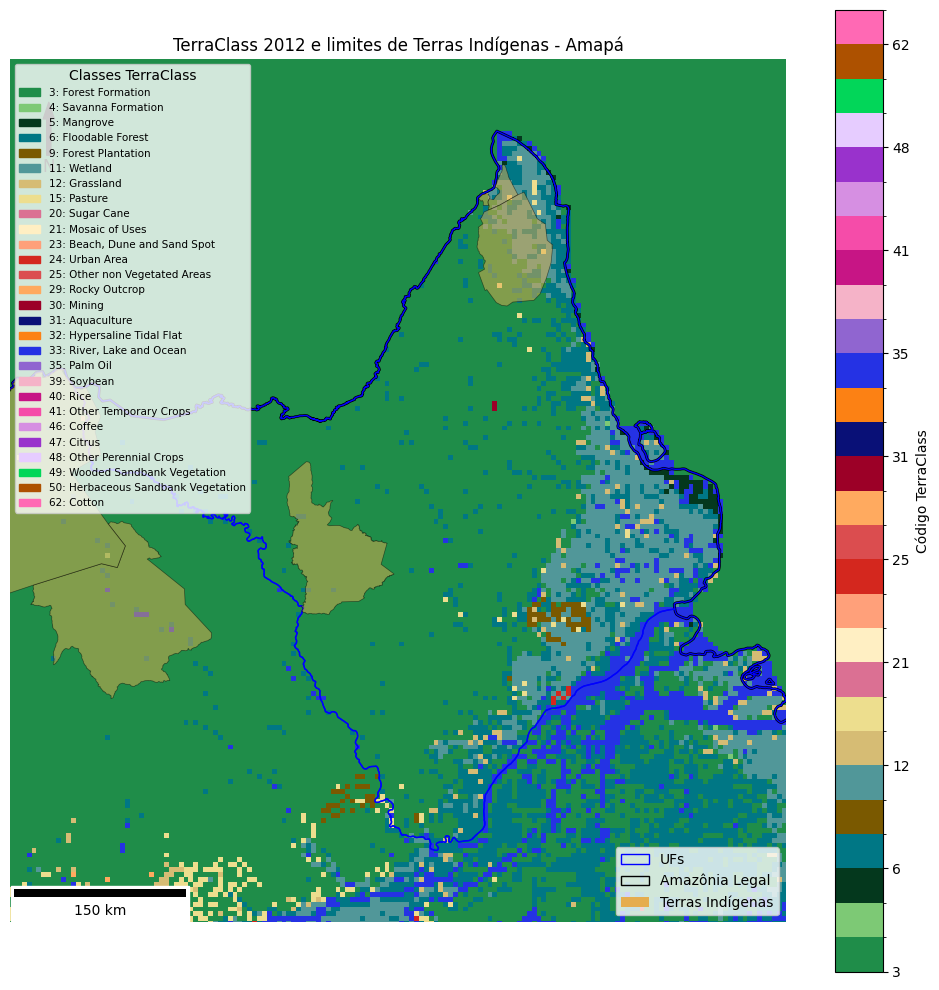

In [14]:
fig, ax = plt.subplots(figsize=(10, 10))

# Plot do raster com colormap discreto
img = ax.imshow(data_albers, cmap=cmap, norm=norm, extent=extent)
plt.colorbar(img, ax=ax, label="Código TerraClass")

# Plot dos shapes
LimitesAML.plot(ax=ax, facecolor="none", edgecolor="black", linewidth=2, label="Amazônia Legal")
LimitesUF.plot(ax=ax, facecolor="none", edgecolor="blue", linewidth=1, label="UFs")
LimitesTI.plot(ax=ax, color="#E5AD4FFF", edgecolor="black", linewidth=0.5, label="Terras Indígenas", alpha=0.5)

# Zoom para o estado do Amapá
ap = LimitesUF[LimitesUF['abbrev_state'] == 'AP']
xmin_ap, ymin_ap, xmax_ap, ymax_ap = ap.total_bounds
margin_x = (xmax_ap - xmin_ap) * 0.1
margin_y = (ymax_ap - ymin_ap) * 0.1
ax.set_xlim(xmin_ap - margin_x, xmax_ap + margin_x)
ax.set_ylim(ymin_ap - margin_y, ymax_ap + margin_y)

# Configurações finais do plot
ax.set_title("TerraClass 2012 e limites de Terras Indígenas - Amapá")
ax.axis("off")

# Rosa dos ventos
arrow_length = 0.075
ax.annotate('N', xy=(0.05, 0.95), xytext=(0.05, 0.95 - arrow_length),
            arrowprops=dict(facecolor='black', width=3, headwidth=8),
            ha='center', va='center', fontsize=12, xycoords=ax.transAxes)

# Barra de escala
scalebar = ScaleBar(dx=1, units="m", dimension="si-length", location="lower left", length_fraction=0.25)
ax.add_artist(scalebar)

# Legenda para os shapes (Amazônia Legal, UFs, Terras Indígenas)
legend_shapes = ax.legend(handles=[
    mpatches.Patch(facecolor='none', edgecolor='blue', label='UFs'),
    mpatches.Patch(facecolor='none', edgecolor='black', label='Amazônia Legal'),
    mpatches.Patch(facecolor='#E5AD4FFF', label='Terras Indígenas')
], loc='lower right')
ax.add_artist(legend_shapes)

# Legenda para as classes do TerraClass
legend_patches = []
for code in sorted(palette.keys()):
    color, label_text = palette[code]
    legend_patches.append(mpatches.Patch(color=color, label=f"{code}: {label_text}"))

legend_classes = ax.legend(
    handles=legend_patches,
    loc='upper left',
    title='Classes TerraClass',
    prop={'size': plt.rcParams['font.size'] * 0.75}  # reduz 25% o tamanho da fonte
)

plt.tight_layout()
plt.savefig("AP_terraclass_2012.png", dpi=300, bbox_inches='tight')
plt.show()

# Comparando com MapBiomas

In [10]:
wcs_url = (
    "https://info.dengue.mat.br/geoserver/wcs?"
    "service=WCS&"
    "version=1.0.0&"
    "request=GetCoverage&"
    "coverage=amazonia_terraclass:terraclass_AMZ.2012.M&"
    "crs=EPSG:4674&"
    "bbox=-73.98318216,-16.66197917,-43.39929216,5.26958083&"
    "width=800&"
    "height=600&"
    "format=GeoTIFF"
)

response = requests.get(wcs_url)
response.raise_for_status()
raster_bytes = response.content

# Definir a projeção destino (Albers para o Brasil)
dst_crs = "+proj=aea +lat_0=-14 +lon_0=-54 +lat_1=-2 +lat_2=-22 +x_0=0 +y_0=0 +ellps=GRS80 +units=m +no_defs"

# Reprojeção do raster
with MemoryFile(raster_bytes) as memfile:
    with memfile.open() as src:
        transform, width, height = calculate_default_transform(
            src.crs, dst_crs, src.width, src.height, *src.bounds
        )
        data_albers = np.empty((height, width), dtype=src.meta['dtype'])
        reproject(
            source=rasterio.band(src, 1),
            destination=data_albers,
            src_transform=src.transform,
            src_crs=src.crs,
            dst_transform=transform,
            dst_crs=dst_crs,
            resampling=Resampling.nearest
        )

# Calcular o extent para o plot (coordenadas no dst_crs)
left   = transform[2]
top    = transform[5]
right  = left + transform[0] * width
bottom = top + transform[4] * height
extent = (left, right, bottom, top)

palette = {
    1:  ("#005500", "VEGETACAO NATURAL FLORESTAL PRIMARIA"),
    2:  ("#0fc80f", "VEGETACAO NATURAL FLORESTAL SECUNDARIA"),
    9:  ("#a8a800", "SILVICULTURA"),
    10: ("#e6a04b", "PASTAGEM ARBUSTIVA/ARBOREA"),
    11: ("#ffec87", "PASTAGEM HERBACEA"),
    12: ("#ff8828", "CULTURA AGRICOLA PERENE"),
    13: ("#996400", "CULTURA AGRICOLA SEMIPERENE"),
    16: ("#ad89cd", "MINERACAO"),
    17: ("#ffa8c0", "URBANIZADA"),
    20: ("#e1e1e1", "OUTROS USOS"),
    22: ("#ff0000", "DESFLORESTAMENTO NO ANO"),
    23: ("#0000ff", "CORPO DAGUA"),
    25: ("#ffffff", "NAO OBSERVADO"),
    50: ("#ff00ff", "NAO FLORESTA"),
    52: ("#ffff00", "CULTURA AGRICOLA TEMPORARIA"),
}

codes = sorted(palette.keys())
colors = [palette[val][0] for val in codes]
cmap = mcolors.ListedColormap(colors, name="my_raster_palette")
boundaries = codes + [codes[-1] + 1]
norm = mcolors.BoundaryNorm(boundaries, len(colors))


# Novo raster (MapBiomas Brasil 2010)
wcs_url = (
    "https://info.dengue.mat.br/geoserver/wcs?"
    "service=WCS&"
    "version=1.0.0&"
    "request=GetCoverage&"
    "coverage=brasil_uso_cob:mapbiomas_brasil_coverage_2012&"
    "crs=EPSG:4674&"
    "bbox=-74.0,-33.8,-34.8,6.0&"
    "width=1000&"
    "height=1000&"
    "format=GeoTIFF"
)

response = requests.get(wcs_url)
response.raise_for_status()
raster_bytes = response.content

# Definir a projeção destino (por exemplo, Albers para o Brasil)
dst_crs = "+proj=aea +lat_0=-14 +lon_0=-54 +lat_1=-2 +lat_2=-22 +x_0=0 +y_0=0 +ellps=GRS80 +units=m +no_defs"

# Reprojeção do raster
with MemoryFile(raster_bytes) as memfile:
    with memfile.open() as src:
        transform, width, height = calculate_default_transform(
            src.crs, dst_crs, src.width, src.height, *src.bounds
        )
        data_albers = np.empty((height, width), dtype=src.meta['dtype'])
        reproject(
            source=rasterio.band(src, 1),
            destination=data_albers,
            src_transform=src.transform,
            src_crs=src.crs,
            dst_transform=transform,
            dst_crs=dst_crs,
            resampling=Resampling.nearest
        )

# Calcular o extent para o plot (coordenadas no dst_crs)
left   = transform[2]
top    = transform[5]
right  = left + transform[0] * width
bottom = top + transform[4] * height
extent = (left, right, bottom, top)

# Nova legenda extraída do QML
palette = {
    3:  ("#1f8d49", "Forest Formation"),
    4:  ("#7dc975", "Savanna Formation"),
    5:  ("#04381d", "Mangrove"),
    6:  ("#007785", "Floodable Forest"),
    9:  ("#7a5900", "Forest Plantation"),
    11: ("#519799", "Wetland"),
    12: ("#d6bc74", "Grassland"),
    15: ("#edde8e", "Pasture"),
    20: ("#db7093", "Sugar Cane"),
    21: ("#ffefc3", "Mosaic of Uses"),
    23: ("#ffa07a", "Beach, Dune and Sand Spot"),
    24: ("#d4271e", "Urban Area"),
    25: ("#db4d4f", "Other non Vegetated Areas"),
    29: ("#ffaa5f", "Rocky Outcrop"),
    30: ("#9c0027", "Mining"),
    31: ("#091077", "Aquaculture"),
    32: ("#fc8114", "Hypersaline Tidal Flat"),
    33: ("#2532e4", "River, Lake and Ocean"),
    35: ("#9065d0", "Palm Oil"),
    39: ("#f5b3c8", "Soybean"),
    40: ("#c71585", "Rice"),
    41: ("#f54ca9", "Other Temporary Crops"),
    46: ("#d68fe2", "Coffee"),
    47: ("#9932cc", "Citrus"),
    48: ("#e6ccff", "Other Perennial Crops"),
    49: ("#02d659", "Wooded Sandbank Vegetation"),
    50: ("#ad5100", "Herbaceous Sandbank Vegetation"),
    62: ("#ff69b4", "Cotton")
}

codes = sorted(palette.keys())
colors = [palette[val][0] for val in codes]
cmap = mcolors.ListedColormap(colors, name="mapbiomas_palette")
boundaries = codes + [codes[-1] + 1]
norm = mcolors.BoundaryNorm(boundaries, len(colors))

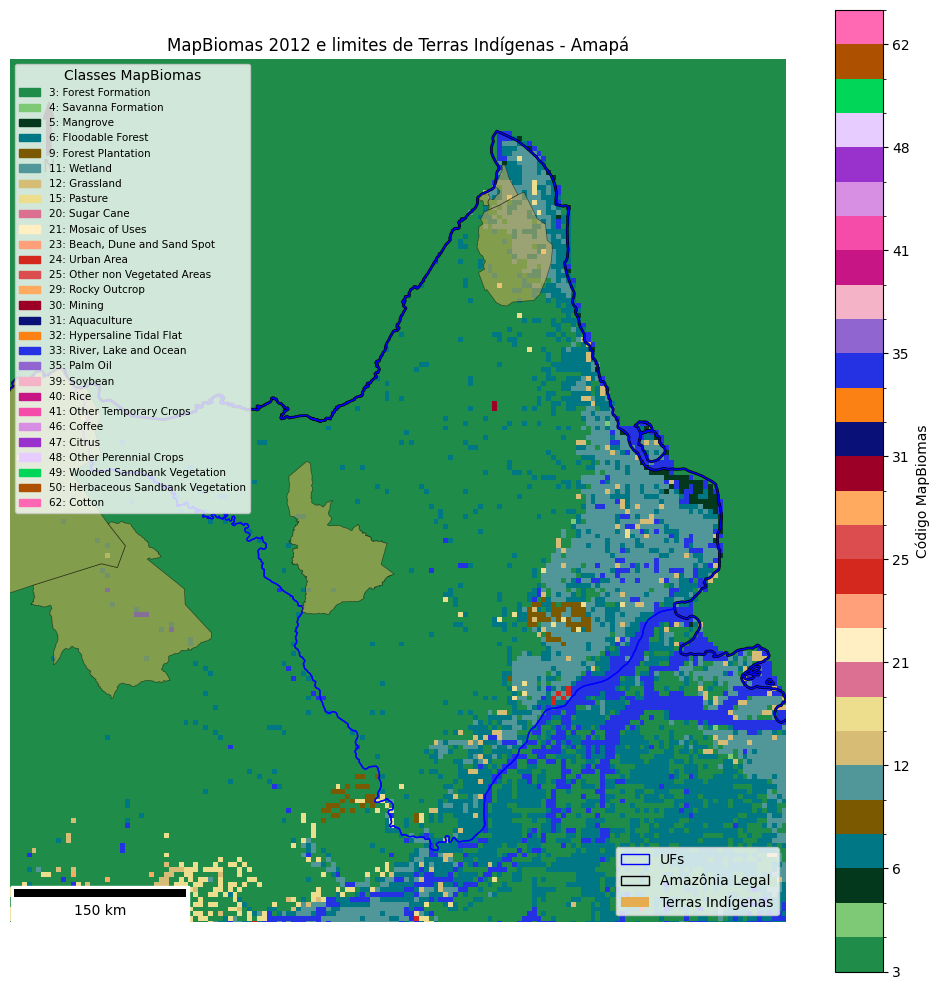

In [13]:
fig, ax = plt.subplots(figsize=(10, 10))

# Plot do raster com colormap discreto
img = ax.imshow(data_albers, cmap=cmap, norm=norm, extent=extent)
plt.colorbar(img, ax=ax, label="Código MapBiomas")

# Plot dos shapes
LimitesAML.plot(ax=ax, facecolor="none", edgecolor="black", linewidth=2, label="Amazônia Legal")
LimitesUF.plot(ax=ax, facecolor="none", edgecolor="blue", linewidth=1, label="UFs")
LimitesTI.plot(ax=ax, color="#E5AD4FFF", edgecolor="black", linewidth=0.5, label="Terras Indígenas", alpha=0.5)

# Zoom para o estado do Amapá
ap = LimitesUF[LimitesUF['abbrev_state'] == 'AP']
xmin_ap, ymin_ap, xmax_ap, ymax_ap = ap.total_bounds
margin_x = (xmax_ap - xmin_ap) * 0.1
margin_y = (ymax_ap - ymin_ap) * 0.1
ax.set_xlim(xmin_ap - margin_x, xmax_ap + margin_x)
ax.set_ylim(ymin_ap - margin_y, ymax_ap + margin_y)

# Configurações finais do plot
ax.set_title("MapBiomas 2012 e limites de Terras Indígenas - Amapá")
ax.axis("off")

# Rosa dos ventos
arrow_length = 0.075
ax.annotate('N', xy=(0.05, 0.95), xytext=(0.05, 0.95 - arrow_length),
            arrowprops=dict(facecolor='black', width=3, headwidth=8),
            ha='center', va='center', fontsize=12, xycoords=ax.transAxes)

# Barra de escala
scalebar = ScaleBar(dx=1, units="m", dimension="si-length", location="lower left", length_fraction=0.25)
ax.add_artist(scalebar)

# Legenda para os shapes (Amazônia Legal, UFs, Terras Indígenas)
legend_shapes = ax.legend(handles=[
    mpatches.Patch(facecolor='none', edgecolor='blue', label='UFs'),
    mpatches.Patch(facecolor='none', edgecolor='black', label='Amazônia Legal'),
    mpatches.Patch(facecolor='#E5AD4FFF', label='Terras Indígenas')
], loc='lower right')
ax.add_artist(legend_shapes)

# Legenda para as classes do TerraClass
legend_patches = []
for code in sorted(palette.keys()):
    color, label_text = palette[code]
    legend_patches.append(mpatches.Patch(color=color, label=f"{code}: {label_text}"))

legend_classes = ax.legend(
    handles=legend_patches,
    loc='upper left',
    title='Classes MapBiomas',
    prop={'size': plt.rcParams['font.size'] * 0.75}  # reduz 25% o tamanho da fonte
)

plt.tight_layout()
plt.savefig("AP_mapbiomas_2012.png", dpi=300, bbox_inches='tight')
plt.show()